In [1]:
import numpy as np
from tqdm import tqdm
import torch
from botorch.models import SingleTaskGP, ModelListGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition.monte_carlo import qUpperConfidenceBound
from botorch.acquisition.monte_carlo import qProbabilityOfImprovement
from botorch.optim import optimize_acqf

from Jcb import calc_basis_matrix
from gen_rand_design import gen_rand_design
tkwargs = {'dtype': torch.float64, 'device': 'cpu'}
from plot_fun import subplot_results

In [2]:
def objective(X, runs, feats, optimality='A', J_cb=None):
    ones = np.array([1]*runs).reshape(-1,1)
    X = X.reshape(runs, feats)
    Zetta = np.concatenate((ones, X), axis=1) if J_cb is None else np.concatenate((ones, X @ J_cb), axis=1)
    M = Zetta.T @ Zetta
    if optimality == 'A':
        try:
            cr = np.trace(np.linalg.inv(M))
        except np.linalg.LinAlgError:
            cr = np.infty
        return np.array([-cr])
    elif optimality == 'D':
        try:
            cr = np.linalg.det(M)
        except np.linalg.LinAlgError:
            cr = np.infty
        return np.array([cr])
    else:
        raise ValueError(f"Invalid criterion {optimality}. "
                         "Criterion should be one of 'D', or 'A'.")

In [3]:
def get_initial_data(runs, feats, optimality='A', J_cb=None):
    X = gen_rand_design(runs=runs, feats=feats)
    X_flat = X.flatten().reshape(1, runs*feats)
    y = objective(X_flat, runs=runs, feats=feats, optimality=optimality, J_cb=J_cb)
    best_y = y.max().item()
    return torch.tensor(X_flat), torch.tensor(y).reshape(-1,1), best_y

In [4]:
def gen_next_point(X, y, best_y, n_exp, acq_f='EI', inequality_constraints=None):
    bounds = torch.Tensor([[-1]*X.shape[1], [1]*X.shape[1]])

    model = SingleTaskGP(X, y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)

    if acq_f == 'EI':
        acq_f = qExpectedImprovement(model=model, best_f=best_y)
    elif acq_f == 'PI':
        acq_f = qProbabilityOfImprovement(model=model, best_f=best_y)
    elif acq_f == 'UCB':
        acq_f = qUpperConfidenceBound(model=model, beta=0.3)
    else:
        raise ValueError(f"Invalid acquisition function {acq_f}. "
                         "acq_f should be one of 'EI', 'PI', or 'UCB'.")

    candidates, _ = optimize_acqf(acq_function=acq_f,
                                  bounds=bounds,
                                  q=n_exp,
                                  num_restarts=10,
                                  raw_samples=1000,
                                  options={"batch_limit":5, "maxiter":200},
                                  inequality_constraints=inequality_constraints)
    return candidates

In [5]:
def bo_loop(epochs, runs, feats, optimality, J_cb, n_exp=1, acq_f='EI', inequality_constraint=None):
    X_init, y_init, best_y_init = get_initial_data(runs=runs, feats=feats, optimality=optimality, J_cb=J_cb)
    History_mat = []
    for i in tqdm(range(epochs)):
        try:
            new_candidates = gen_next_point(X=X_init, y=y_init, best_y=best_y_init, n_exp=n_exp, acq_f=acq_f, inequality_constraints=inequality_constraint)
        except:
            X_init = X_init[:-1, :]
            y_init = y_init[:-1, :]
            continue
        new_results = objective(X=new_candidates, runs=runs, feats=feats, optimality=optimality, J_cb=J_cb)
        new_results = torch.Tensor(new_results.reshape(-1,1))

        X_init = torch.cat([X_init, new_candidates])
        y_init = torch.cat([y_init, new_results])
        best_y_init = y_init.max().item()
        History_mat.append([i, -best_y_init, new_candidates])

    History_mat = np.array(History_mat, dtype=object)
    epochs_min_id = History_mat[:,1].argmin()
    Best_des = History_mat[epochs_min_id, 2]
    Best_cr = History_mat[epochs_min_id, 1]
    return np.array(Best_des).reshape(runs, feats), Best_cr

In [6]:
n_x = 2
n_b = 2
epochs = 250
runs = 4

In [7]:
J_cb = calc_basis_matrix(x_basis=n_x, b_basis=n_b)
Design, Cr = bo_loop(epochs=epochs,
                     runs=runs,
                     feats=n_x,
                     optimality='A',
                     J_cb=J_cb,
                     n_exp=1,
                     acq_f='EI',
                     inequality_constraint=None)

 50%|█████     | 126/250 [01:41<03:59,  1.93s/it]/Users/thodorisladas/miniforge3/envs/optidex/lib/python3.10/site-packages/botorch/fit.py:171: RuntimeWarning: All attempts to fit the model have failed. For more information, try enabling botorch.settings.debug mode.
  warn(str(err), RuntimeWarning)
 57%|█████▋    | 143/250 [02:32<05:40,  3.19s/it]/Users/thodorisladas/miniforge3/envs/optidex/lib/python3.10/site-packages/botorch/fit.py:171: RuntimeWarning: All attempts to fit the model have failed. For more information, try enabling botorch.settings.debug mode.
  warn(str(err), RuntimeWarning)
 62%|██████▏   | 155/250 [03:31<07:35,  4.80s/it]/Users/thodorisladas/miniforge3/envs/optidex/lib/python3.10/site-packages/botorch/fit.py:171: RuntimeWarning: All attempts to fit the model have failed. For more information, try enabling botorch.settings.debug mode.
  warn(str(err), RuntimeWarning)
 70%|███████   | 176/250 [04:53<05:09,  4.18s/it]/Users/thodorisladas/miniforge3/envs/optidex/lib/pytho

In [8]:
Z = np.concatenate((np.array([1]*4).reshape(-1,1), Design @ J_cb) ,axis=1)
np.trace(np.linalg.inv(Z.T @ Z))

8.75

In [9]:
Design

array([[-1.,  1.],
       [-1.,  1.],
       [ 1.,  1.],
       [ 1., -1.]], dtype=float32)

In [19]:
Cr

8.75

In [27]:
ZZ = Design @ J_cb

0.1875

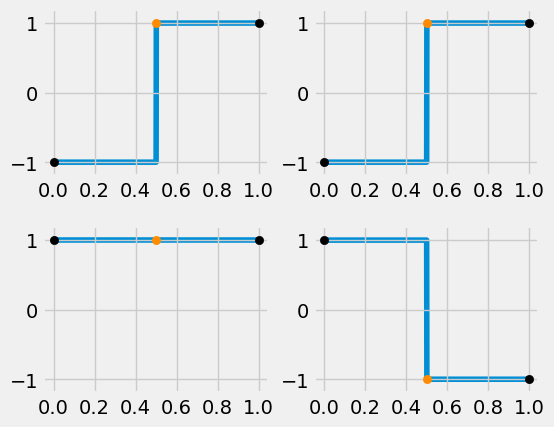

In [11]:
subplot_results(sub_x=2, sub_y=2, T=np.linspace(0,1,1000), results=Design, J_cb=J_cb)